# Study C
This notebook shows the full workflow for building models, simulating growth and obtaining SCFA predictions from data collected by the _ex vivo_ study conducted by the Gurry Lab in 2021 (Study C)

In [6]:
import pandas as pd
import numpy as np 
# import qiime2 as q2
# import micom
# import micom.measures
import scipy
from plotnine import *
import os
from tqdm import tqdm



%matplotlib inline

## Flux Calculation
This function will calculate production rate from the experimental SCFA measurements, as well as standard deviations, and concatenate them into a dataframe

In [4]:
def flux_calculate(arg):
    os.chdir('/proj/gibbons/nbohmann/exvivo/gurry1/data/gc_data/normalized')
    file = pd.read_csv(arg,index_col = 0)
    file = file[['but','pro','ace']].dropna()
    file = file[~file.index.str.contains("QC")]
    file['sample'] = file.index.str.split('-').str[0]
    file['treatment'] = file.index.str.split('-').str[1]
    file['timepoint'] = file.index.str.split('-').str[2]
    file['replicate'] = file.index.str.split('-').str[4]
    file = file.dropna()
    baseline = file[file.timepoint.str.contains('0')]
    baseline['treatment'] = 'INUL'
    file = pd.concat([file,baseline])
    baseline['treatment'] = 'PECT'
    file = pd.concat([file,baseline])
    file = file[(file.index.str.contains('CTRL'))|
                (file.index.str.contains('PECT'))|
                (file.index.str.contains('INUL'))]
    file = file[~file.timepoint.str.contains('0')]
    file = file.sort_values(by=['sample','treatment','replicate','timepoint'])
    file.set_index(['sample','treatment','replicate','timepoint'],inplace = True)
    file = file.groupby(['sample','treatment','replicate']).diff().dropna().reset_index()
    stdev = file.groupby(['sample','treatment']).std(numeric_only = True).reset_index().set_index('treatment')
    file = file.groupby(['sample','treatment']).mean(numeric_only = True).reset_index()
    file['but_dev'] = file['treatment'].map(stdev['but'].to_dict())
    file['ppa_dev'] = file['treatment'].map(stdev['pro'].to_dict())
    file['ace_dev'] = file['treatment'].map(stdev['ace'].to_dict())

    return file

In [5]:
def calculate_baseline(arg):
    os.chdir('/proj/gibbons/nbohmann/exvivo/gurry1/data/gc_data/normalized')
    file = pd.read_csv(arg,index_col = 0)
    file = file[['but','pro','ace']].dropna()
    file = file[~file.index.str.contains("QC")]
    file['sample'] = file.index.str.split('-').str[0]
    file['treatment'] = file.index.str.split('-').str[1]
    file['timepoint'] = file.index.str.split('-').str[2]
    file['replicate'] = file.index.str.split('-').str[4]
    file = file.dropna()
    baseline = file[file.timepoint.str.contains('0')]
    baseline = baseline.groupby('sample').mean()
    

    return baseline

Here we'll iterate the above function across GC-MS data for each sample.

In [6]:
sample_list = ['H008-a.csv','H009-a.csv','H010-a.csv','H012-a.csv','H019-a.csv',
               'H020-a.csv','H021-a.csv','H025-a.csv','H028-a.csv','H029-a.csv']
os.chdir('/proj/gibbons/nbohmann/exvivo/gurry1/data/gc_data/normalized')
scfa = pd.DataFrame([])
for x in tqdm(sample_list):
    scfa = pd.concat([scfa,flux_calculate(x)])
scfa.reset_index(inplace = True,drop = True)
scfa['index'] = scfa['sample']+'_'+scfa['treatment']
scfa.set_index('index',inplace = True)
acetateMeasured = scfa['ace'].to_dict()
butyrateMeasured = scfa['but'].to_dict()
propionateMeasured = scfa['pro'].to_dict()
acetateMeasuredSEM = scfa['ace_dev'].to_dict()
butyrateMeasuredSEM = scfa['but_dev'].to_dict()
propionateMeasuredSEM = scfa['ppa_dev'].to_dict()
baseline = pd.DataFrame([])
for x in tqdm(sample_list):
    baseline = pd.concat([baseline,calculate_baseline(x)])

  0%|                                                    | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_3265813/1596247356.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  0%|                                                    | 0/10 [00:00<?, ?it/s]


TypeError: std() got an unexpected keyword argument 'numeric_only'

## Taxonomy Table
First, we pull in the taxonomy table, matching each feature ID in the qiime2 output to a microbial taxa at the species level. We will build our models at the genus level, so collapse to this rank

In [7]:
os.chdir('/proj/gibbons/nbohmann/exvivo/gurry1/data/qiime2/taxonomy/data')
taxa = pd.read_csv('taxonomy.tsv',sep='\t') # read table
taxa.set_index('Feature ID',inplace=True)
taxa = taxa.Taxon.str.split(';',expand=True) # split ranks
taxa = taxa.rename(columns = {0:'Kingdom',1:'Phylum',2:'Class',3:'Order',4:'Family',5:'Genus',6:'Species'})
taxa = taxa.dropna(subset = ['Genus']) # drop undefined columns
taxa = taxa.drop(columns = ['Species']) # drop species column
taxa = taxa.apply(lambda column: column.str.split('_').str[2]) # remove prefixes
taxa = (taxa.apply(lambda row: ";".join(row.str.capitalize().fillna("")), axis=1)
        .to_frame().rename(columns = {0:'taxon'})) # join columns into taxon identifier
taxa

,taxon
Feature ID,
9354f0ff1ab19470a17b149cfad93ddd,Bacteria;Firmicutes;Clostridia;Clostridiales;R...
8c301982c0bbe7b8e5bc5907df89bb2b,Bacteria;Firmicutes;Clostridia;Clostridiales;R...
240f4ed3e5a6fbeeff60fc3e031eb2bc,Bacteria;Firmicutes;Clostridia;Clostridiales;R...
dcba63bbff80a199a8e6392e4e7e1abe,Bacteria;Firmicutes;Clostridia;Clostridiales;R...
bdc1cd891474b9c587f83e9c93690911,Bacteria;Firmicutes;Clostridia;Clostridiales;R...
...,...
9ce589b72e392c47e9d87ad0dc06de75,Bacteria;Firmicutes;Clostridia;Clostridiales;L...
b8b0d74ce655fffa813a4838aa53b74d,Bacteria;Firmicutes;Clostridia;Clostridiales;R...
6bccf2cf07466a2379206c34ad92c801,Bacteria;Firmicutes;Clostridia;Clostridiales;R...


Next we'll pull in the abundance table, with read counts for all present taxa. We'll drop those that aren't identified in the taxon list, and sum together duplicates. 

In [10]:
os.chdir('/proj/gibbons/nbohmann/exvivo/gurry1/data/qiime2/')
unrarefied_table = q2.Artifact.load('table.qza') # read table
abundance = unrarefied_table.view(pd.DataFrame).reset_index().rename(columns = {'index':'sample_id'})
to_drop = (abundance[abundance.columns[1:]].columns[~abundance[abundance.columns[1:]].
                                                    columns.isin(taxa.index)].to_list()) # taxa to drop
abundance = abundance.drop(columns = to_drop)
abundance = abundance.rename(columns = taxa['taxon'].to_dict())
abundance = pd.melt(abundance, id_vars = 'sample_id', value_vars = abundance.columns[:-1],
                    var_name = 'id', value_name = 'abundance') # melt into long form df 
abundance = abundance.groupby(by = ['sample_id','id']).sum().reset_index()
abundance['genus'] = abundance['id'].str.split(';').str[-1] # need a genus column in df 
abundance

,sample_id,id,abundance,genus
0,H008,Archaea;Euryarchaeota;Methanobacteria;Methanob...,44.0,Methanobrevibacter
1,H008,Bacteria;Actinobacteria;Actinobacteria;Actinom...,0.0,Schaalia
2,H008,Bacteria;Actinobacteria;Actinobacteria;Bifidob...,26.0,Bifidobacterium
3,H008,Bacteria;Actinobacteria;Actinobacteria;Microco...,0.0,Rothia
4,H008,Bacteria;Actinobacteria;Coriobacteriia;Corioba...,88.0,Collinsella
...,...,...,...,...
1125,H029,Bacteria;Proteobacteria;Epsilonproteobacteria;...,0.0,Helicobacter
1126,H029,Bacteria;Proteobacteria;Gammaproteobacteria;En...,139.0,Morganella
1127,H029,Bacteria;Proteobacteria;Gammaproteobacteria;Ps...,0.0,Pseudomonas
1128,H029,Bacteria;Tenericutes;Mollicutes;Entomoplasmata...,0.0,Spiroplasma


## Build Models
Now, we'll build our models, with cutoff of 0.001

In [ ]:
manifest = micom.workflows.build(abundance,
                               out_folder = '/proj/gibbons/nbohmann/exvivo/gurry1/micom/16S/16S_models_001/',
                               model_db = '/proj/gibbons/refs/micom_dbs/agora103_genus.qza',
                               cutoff = 0.001,
                               threads = 20)

## Load Medium
Load in the carbon-stripped European Diet, and construct the intervention diets by augmenting with inulin and pectin

In [4]:
medium = pd.read_csv('/proj/gibbons/nbohmann/exvivo/diets/western_diet_depleted.csv')
medium['index'] = medium['reaction']
medium.set_index('index',inplace = True)
medium.at['EX_h2o_m','flux']=100000
medium['flux'] = medium['flux']/10


medium = pd.concat([medium, 
                    pd.DataFrame({'metabolite':['nh4_m', 
                                                'strch1_m', 'strch2_m','starch1200_m', 
                                                'dextrin_m','cellul_m'],
                                  'flux':[5,
                                          13.3, 13.3, 0.133,
                                          13.3, 0.00067],
                                  'reaction':['EX_nh4_m',
                                              'EX_strch1_m', 'EX_strch2_m', 'EX_starch1200_m', 
                                              'EX_dextrin_m', 'EX_cellul_m']},
                                 index = ['EX_nh4_m',
                                         'EX_strch1_m','EX_strch2_m', 'EX_starch1200_m',
                                         'EX_dextrin_m', 'EX_cellul_m'])])

controlMedium = medium


pectinMedium = pd.concat([medium,
                           pd.DataFrame({'reaction':['EX_pect_m', 'EX_amylopect900_m'],
                                         'metabolite':['pect_m', 'amylopect900_m'],
                                         'global_id':['EX_pect(e)', 'EX_amylopect900(e)'],
                                         'flux':[1,0]
                                        },index = ['pect_m','amylopect900_m'])])


inulinMedium = pd.concat([medium,
                           pd.DataFrame({'reaction':['EX_inulin_m'],
                                         'metabolite':['inulin_m'],
                                         'global_id':['EX_inulin(e)'],
                                         'flux':[14]
                                        },index = ['inulin_m'])])
medium.to_csv('/users/nbohmann/exvivo/studyCmedium.csv')

## Grow Models
Now we'll grow the samples using the respective media we constructed

In [44]:
manifest = pd.read_csv('/proj/gibbons/nbohmann/exvivo/gurry1/micom/16S/16S_models/manifest.csv')
controlGrowth = micom.workflows.grow(manifest,
                                  model_folder='/proj/gibbons/nbohmann/exvivo/gurry1/micom/16S/16S_models/',
                                  medium = controlMedium, 
                                  tradeoff = 0.7,
                                  strategy ='none', 
                                  threads = 20)
pectGrowth = micom.workflows.grow(manifest,
                                 model_folder='/proj/gibbons/nbohmann/exvivo/gurry1/micom/16S/16S_models/',
                                 medium = pectinMedium, 
                                 tradeoff = 0.7, 
                                 strategy = 'none', 
                                 threads = 20)
inulinGrowth = micom.workflows.grow(manifest, 
                                 model_folder='/proj/gibbons/nbohmann/exvivo/gurry1/micom/16S/16S_models/',
                                 medium = inulinMedium, 
                                 tradeoff = 0.7, 
                                 strategy = 'none',
                                 threads = 20)

Output()

Output()

Output()

## Compare SCFA Fluxes
We can now extract the production fluxes of SCFAs from each growth simulation, and construct a dataframe with both measured and predicted production rates.

In [45]:
controlProduction = micom.measures.production_rates(controlGrowth)
controlProduction['treatment'] = 'CTRL'
pectProduction = micom.measures.production_rates(pectGrowth)
pectProduction['treatment'] = 'PECT'
inulinProduction = micom.measures.production_rates(inulinGrowth)
inulinProduction['treatment'] = 'INUL'
production = pd.concat([controlProduction, pectProduction, inulinProduction])
production['sample_id'] = production['sample_id']+'_'+production['treatment']
scfas = production[(production['name']==('butyrate'))|
                   (production['name']==('acetate'))|
                   (production['name']==('propionate'))]

res = pd.pivot(scfas, index = 'sample_id', 
                         columns = 'name',
                         values = 'flux')
res.rename(columns = {'acetate':'acetatePredicted',
                      'butyrate':'butyratePredicted',
                      'propionate':'propionatePredicted'
                      }, inplace = True
          )
res['acetateMeasured'] = res.index.map(acetateMeasured)
res['butyrateMeasured'] = res.index.map(butyrateMeasured)
res['propionateMeasured'] = res.index.map(propionateMeasured)
res['acetateMeasuredSEM'] = res.index.map(acetateMeasuredSEM)
res['butyrateMeasuredSEM'] = res.index.map(butyrateMeasuredSEM)
res['propionateMeasuredSEM'] = res.index.map(propionateMeasuredSEM)
res['treatment'] = res.index.str.split('_').str[1].str.replace(
    'CTRL','Control').str.replace(
    'INUL','Inulin').str.replace(
    'PECT','Pectin')
res

name,acetatePredicted,butyratePredicted,propionatePredicted,acetateMeasured,butyrateMeasured,propionateMeasured,acetateMeasuredSEM,butyrateMeasuredSEM,propionateMeasuredSEM,treatment
sample_id,,,,,,,,,,
H008_CTRL,344.530509,55.313315,134.862568,3.630993,0.289049,0.070937,0.029568,0.054781,0.094993,Control
H008_INUL,459.430607,100.431611,232.588719,2.521249,1.473728,0.853200,0.890141,0.132081,0.020859,Inulin
H008_PECT,413.384691,43.758816,204.008289,1.377937,0.542584,0.396071,1.449418,0.088096,0.082336,Pectin
H009_CTRL,326.699377,59.759345,85.922607,0.164601,0.218248,0.092502,0.049103,0.019190,0.008924,Control
H009_INUL,430.277644,120.999169,147.191381,0.135468,0.505528,0.122654,0.105428,0.007005,0.001216,Inulin
H009_PECT,426.713833,138.389538,128.321226,0.009897,0.327691,0.010046,0.032118,0.005439,0.003179,Pectin
H010_CTRL,330.247146,58.435467,170.137976,3.214500,0.179220,0.319464,4.545364,0.000661,0.006166,Control
H010_INUL,455.395061,91.657539,257.385934,10.123713,0.468322,0.340310,0.240566,0.030997,0.033941,Inulin
H010_PECT,454.590784,65.095751,193.401046,10.176295,0.191882,0.180247,0.221434,0.044403,0.064337,Pectin


In [ ]:
pred16S = res[['acetatePredicted','butyratePredicted','propionatePredicted']]
pred16S = pred16S.rename(columns = {'acetatePredicted':'acetatePredicted16S',
                                      'butyratePredicted':'butyratePredicted16S',
                                      'propionatePredicted':'propionatePredicted16S'})

## Plot Results
Finally, we'll plot predicted vs measured fluxes against each other

In [ ]:
fig1 = (ggplot(
    res, aes(x = 'acetateMeasured', y = 'acetatePredicted'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 8)
    +geom_smooth(aes(groups = 'treatment', color = 'treatment', fill = 'treatment'),
                 method = 'lm', linetype = '--')
    # +geom_errorbar(aes(x = 'acetateMeasured', 
    #                    ymin = 'acetatePredicted - acetatePredictedSEM',
    #                    ymax = 'acetatePredicted + acetatePredictedSEM'))
    +geom_errorbarh(aes(y = 'acetatePredicted', 
                       xmin = 'acetateMeasured - acetateMeasuredSEM',
                       xmax = 'acetateMeasured + acetateMeasuredSEM'), height = 10)
    +geom_rug(aes(color = 'treatment'),sides = 'tr', size = 2)
    +scale_color_manual(limits = ['Control','Inulin','Pectin'], 
                        values = ['cornflowerblue', 'coral', 'mediumseagreen'])
    +scale_fill_manual(limits = ['Control','Inulin','Pectin'], 
                       values = ['cornflowerblue', 'coral', 'mediumseagreen'])
    +labs(title='Acetate',
          x='Measured ($\dfrac{mmol}{L*h}$)',
          y = 'Predicted ($\dfrac{mmol}{gDCW*h}$)',
          color = 'Treatment',fill = 'Treatment')
    +theme(text = element_text(size=35, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig1

/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 3 rows containing missing values.
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_errorbarh : Removed 3 rows containing missing values.


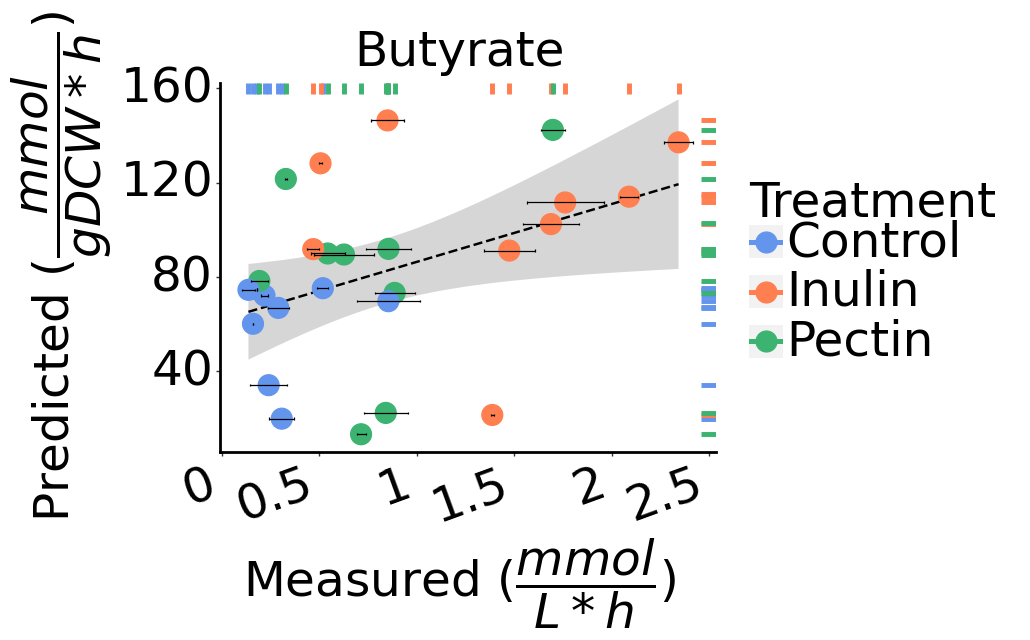

<ggplot: (8775616066690)>

In [13]:
fig2 = (ggplot(
    res, aes(x = 'butyrateMeasured', y = 'butyratePredicted'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 8)
    # +geom_smooth(aes(groups = 'treatment', color = 'treatment', fill = 'treatment'),
    #              method = 'lm', linetype = '--')
    # +geom_errorbar(aes(x = 'butyrateMeasured', 
    #                    ymin = 'butyratePredicted - butyratePredictedSEM',
    #                    ymax = 'butyratePredicted + butyratePredictedSEM'), width = .1)
    +geom_errorbarh(aes(y = 'butyratePredicted', 
                       xmin = 'butyrateMeasured - butyrateMeasuredSEM',
                       xmax = 'butyrateMeasured + butyrateMeasuredSEM'), height = 1)
    +geom_rug(aes(color = 'treatment'),sides = 'tr', size = 2)
    +scale_color_manual(limits = ['Control','Inulin','Pectin'], 
                        values = ['cornflowerblue', 'coral', 'mediumseagreen'])
    +scale_fill_manual(limits = ['Control','Inulin','Pectin'], 
                       values = ['cornflowerblue', 'coral', 'mediumseagreen'])    
    +labs(title='Butyrate',
          x='Measured ($\dfrac{mmol}{L*h}$)',
          y = 'Predicted ($\dfrac{mmol}{gDCW*h}$)',
          color = 'Treatment',fill = 'Treatment')
    +theme(
            text = element_text(size=35, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig2

/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 3 rows containing missing values.
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_errorbarh : Removed 3 rows containing missing values.


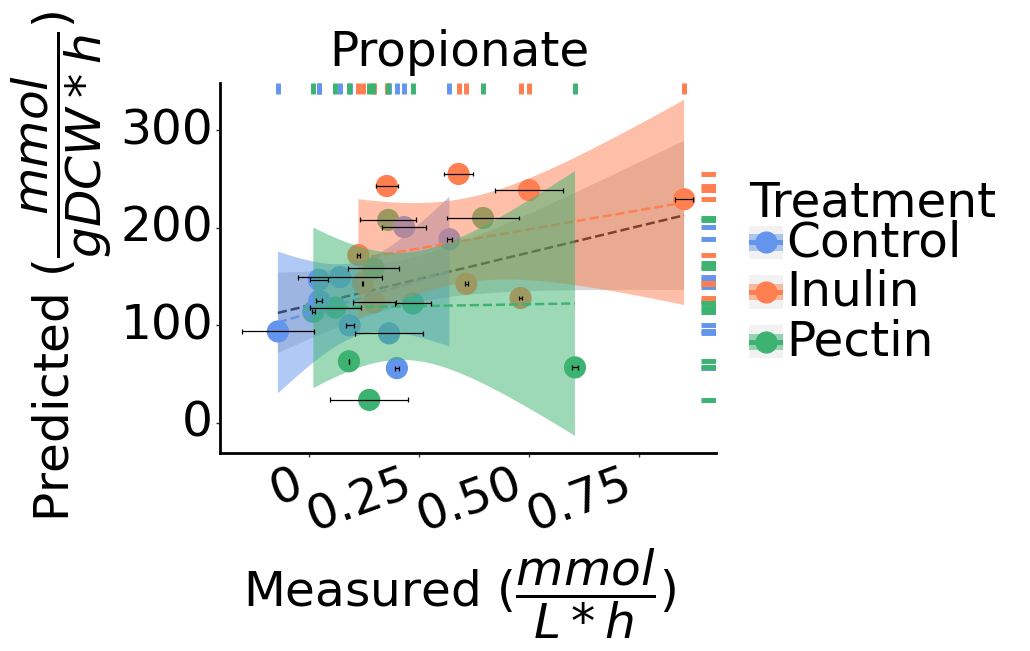

<ggplot: (8775623316167)>

In [14]:
fig3 = (ggplot(
    res, aes(x = 'propionateMeasured', y = 'propionatePredicted'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 8)
    +geom_smooth(aes(groups = 'treatment', color = 'treatment', fill = 'treatment'),
                 method = 'lm', linetype = '--', alpha = .5)
    # +geom_errorbar(aes(x = 'propionateMeasured', 
    #                    ymin = 'propionatePredicted - propionatePredictedSEM',
    #                    ymax = 'propionatePredicted + propionatePredictedSEM'), width = .1)
    +geom_errorbarh(aes(y = 'propionatePredicted', 
                       xmin = 'propionateMeasured - propionateMeasuredSEM',
                       xmax = 'propionateMeasured + propionateMeasuredSEM'), height = 5)
    +geom_rug(aes(color = 'treatment'),sides = 'tr', size = 2)
    +scale_color_manual(limits = ['Control','Inulin','Pectin'], 
                        values = ['cornflowerblue', 'coral', 'mediumseagreen'])
    +scale_fill_manual(limits = ['Control','Inulin','Pectin'], 
                       values = ['cornflowerblue', 'coral', 'mediumseagreen'])
   
    +labs(title='Propionate',
          x='Measured ($\dfrac{mmol}{L*h}$)',
          y = 'Predicted ($\dfrac{mmol}{gDCW*h}$)', 
         color = 'Treatment', fill = 'Treatment')
    +theme(text = element_text(size=35, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig3

In [ ]:
ggsave(fig1,'/users/nbohmann/studyCac.png', dpi = 300)
ggsave(fig2,'/users/nbohmann/studyCbut.png', dpi = 300)
ggsave(fig3,'/users/nbohmann/studyCppa.png', dpi = 300)

## Save all results

In [58]:
res.to_csv('/proj/gibbons/scfa_predictions/results/studyC.csv')

# Metagenome Data
We'll conduct the same analysis as above with shotgun metagenomic data to compare the two methods for use in metabolic modeling

## Taxonomy Table
First, we pull in the taxonomy table, matching each feature ID in the qiime2 output to a microbial taxa at the species level. We will build our models at the genus level, so collapse to this rank

In [13]:
os.chdir('/proj/gibbons/2021_gurry_exvivo/mgs/data/')
abundance = pd.read_csv('S_counts.csv')
abundance['id'] = abundance[['k','p','c','o','f','g','s']].apply(lambda x: ';'.join(x.dropna().values.tolist()), axis=1)
abundance = abundance[['sample','id','reads','s']].rename(columns = {'sample':'sample_id','reads':'abundance','s':'species'})
abundance = abundance[abundance['id'].str.startswith('Bacteria')]
abundance = abundance.groupby(by = ['sample_id','id','species']).sum().reset_index()
# abundance['species'] = abundance['species'].str.split('_').str[1].str.lower()
abundance['species'] = abundance.species.str.replace('_',' ')

In [15]:
pd.pivot_table(abundance, 
               index = 'sample_id',
               columns = 'species',
               values = 'abundance').fillna(0.0).to_csv('/users/nbohmann/exvivo/studyC.csv')

## Build Models
Now, we'll build our models, with cutoff of 0.001

In [ ]:
manifest = micom.workflows.build(abundance, 
                                 '/proj/gibbons/nbohmann/exvivo/databases/agora103_species.qza',
                                 '/proj/gibbons/nbohmann/exvivo/gurry1/micom/metagenome/models_sp',
                                 cutoff = 0.001,
                                 threads = 20)

## Grow Models
Now we'll grow the samples using the respective media we constructed

In [46]:
manifest = pd.read_csv('/proj/gibbons/nbohmann/exvivo/gurry1/micom/metagenome/models_sp/manifest.csv')
controlGrowth = micom.workflows.grow(manifest,
                                  model_folder='/proj/gibbons/nbohmann/exvivo/gurry1/micom/metagenome/models_sp/',
                                  medium = controlMedium, 
                                  tradeoff = 0.7,
                                  strategy ='none', 
                                  threads = 20)
pectinGrowth = micom.workflows.grow(manifest,
                                 model_folder='/proj/gibbons/nbohmann/exvivo/gurry1/micom/metagenome/models_sp/',
                                 medium = pectinMedium, 
                                 tradeoff = 0.7, 
                                 strategy = 'none', 
                                 threads = 20)
inulinGrowth = micom.workflows.grow(manifest, 
                                 model_folder='/proj/gibbons/nbohmann/exvivo/gurry1/micom/metagenome/models_sp/',
                                 medium = inulinMedium, 
                                 tradeoff = 0.7, 
                                 strategy = 'none',
                                 threads = 20)

Output()

Output()

Output()

## Compare SCFA Fluxes
We can now extract the production fluxes of SCFAs from each growth simulation, and construct a dataframe with both measured and predicted production rates.

In [47]:
controlProduction = micom.measures.production_rates(controlGrowth)
controlProduction['treatment'] = 'CTRL'
pectinProduction = micom.measures.production_rates(pectinGrowth)
pectinProduction['treatment'] = 'PECT'
inulinProduction = micom.measures.production_rates(inulinGrowth)
inulinProduction['treatment'] = 'INUL'
production = pd.concat([controlProduction, pectinProduction, inulinProduction])
production['sample_id'] = production['sample_id']+'_'+production['treatment']
scfas = production[(production['name']==('butyrate'))|
                   (production['name']==('acetate'))|
                   (production['name']==('propionate'))]

res = pd.pivot(scfas, index = 'sample_id', 
                         columns = 'name',
                         values = 'flux')
res.rename(columns = {'acetate':'acetatePredicted',
                      'butyrate':'butyratePredicted',
                      'propionate':'propionatePredicted'
                      }, inplace = True
          )
res['acetateMeasured'] = res.index.map(acetateMeasured)
res['butyrateMeasured'] = res.index.map(butyrateMeasured)
res['propionateMeasured'] = res.index.map(propionateMeasured)
res['acetateMeasuredSEM'] = res.index.map(acetateMeasuredSEM)
res['butyrateMeasuredSEM'] = res.index.map(butyrateMeasuredSEM)
res['propionateMeasuredSEM'] = res.index.map(propionateMeasuredSEM)
res['treatment'] = res.index.str.split('_').str[1].str.replace(
    'CTRL','Control').str.replace(
    'INUL','Inulin').str.replace(
    'PECT','Pectin')

In [48]:
predMeta = res[['acetatePredicted','butyratePredicted','propionatePredicted']]
predMeta = predMeta.rename(columns = {'acetatePredicted':'acetatePredictedMeta',
                                      'butyratePredicted':'butyratePredictedMeta',
                                      'propionatePredicted':'propionatePredictedMeta'})

In [23]:
pred = pd.concat([pred16S, predMeta], axis = 1)
pred['treatment'] = pred.index.str.split('_').str[1].str.replace(
    'CTRL','Control').str.replace(
    'INUL','Inulin').str.replace(
    'PECT','Pectin')

NameError: name 'pred16S' is not defined

In [ ]:
pred['donor'] = pred.index.str.split('_').str[0]
pred = pd.melt(pred,
                id_vars = ['treatment', 'donor'],
                value_vars = ['butyratePredicted16S','butyratePredictedMeta',
               'propionatePredicted16S', 'propionatePredictedMeta'],
                value_name = 'flux', 
                var_name = 'analyte')
pred['source'] = pred['analyte'].str.split('Predicted').str[1]
pred['analyte'] = pred['analyte'].str.split("([A-Z][^A-Z]*)").str[0]
pred = pd.pivot_table(pred,
                    index = ['treatment','donor','analyte'],
                     columns = 'source',
                     values = 'flux').reset_index()

pred['analyte'] = pred['analyte'].str.capitalize()

## 16S vs Metagenome Predictions

In [49]:
fig4 = (ggplot(
    pred, aes(x = '16S', y = 'Meta'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 5)
    # +geom_smooth(aes(groups = 'treatment', color = 'treatment', fill = 'treatment'),
    #              method = 'lm', linetype = '--')
    +scale_color_manual(limits = ['Control','Inulin','Pectin'], 
                        values = ['cornflowerblue', 'coral', 'mediumseagreen'])
    +scale_fill_manual(limits = ['Control','Inulin','Pectin'], 
                       values = ['cornflowerblue', 'coral', 'mediumseagreen'])
    +facet_wrap('analyte', scales = 'free_x')
    +labs(title='',
          x='Predicted, Metagenome Models,\n Species Level (mmol/gDW/h)',
          y = 'Predicted, Metagenome Models,\n Genus Level (mmol/gDW/h)',
          color = 'Treatment',fill = 'Treatment')
    +theme(figure_size = (8, 6),text = element_text(size=20, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig4

NameError: name 'pred' is not defined

In [ ]:
pred = pred.dropna(how = 'any')
scipy.stats.linregress(pred[(pred['analyte']=='Butyrate')]['16S'],pred[(pred['analyte']=='Butyrate')]['Meta'])

In [ ]:
fig5 = (ggplot(
    pred, aes(x = 'butyratePredicted16S', y = 'butyratePredictedMeta'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 5)
    +geom_smooth(aes(groups = 'treatment', color = 'treatment', fill = 'treatment'),
                 method = 'lm', linetype = '--')
    +geom_rug(aes(color = 'treatment'),sides = 'tr', size = 2)
    +scale_color_manual(limits = ['Control','Inulin','Pectin'], 
                        values = ['cornflowerblue', 'coral', 'mediumseagreen'])
    +scale_fill_manual(limits = ['Control','Inulin','Pectin'], 
                       values = ['cornflowerblue', 'coral', 'mediumseagreen'])
    +labs(title='',
          x='',
          y = '',
          color = 'Treatment',fill = 'Treatment')
    +theme(text = element_text(size=35, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig5

In [ ]:
fig6 = (ggplot(
    pred, aes(x = 'propionatePredicted16S', y = 'propionatePredictedMeta'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 5)
    +geom_smooth(aes(groups = 'treatment', color = 'treatment', fill = 'treatment'),
                 method = 'lm', linetype = '--')
    +geom_rug(aes(color = 'treatment'),sides = 'tr', size = 2)
    +scale_color_manual(limits = ['Control','Inulin','Pectin'], 
                        values = ['cornflowerblue', 'coral', 'mediumseagreen'])
    +scale_fill_manual(limits = ['Control','Inulin','Pectin'], 
                       values = ['cornflowerblue', 'coral', 'mediumseagreen'])
    +labs(title='',
          x='',
          y = '',
          color = 'Treatment',fill = 'Treatment')
    +theme(text = element_text(size=35, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig6

In [ ]:
ggsave(fig4,'/users/nbohmann/metaspvsmetagenus.png', dpi = 300)
# ggsave(fig6,'/users/nbohmann/propionate_genus.png', dpi = 300)


In [ ]:
pred = pred.dropna(how = 'any')
scipy.stats.linregress(pred['propionatePredicted16S'],
                       pred['propionatePredictedMeta'])

In [ ]:
scipy.stats.linregress(pred[pred['treatment']=='Pectin']['acetatePredicted16S'],
                       pred[pred['treatment']=='Pectin']['acetatePredictedMeta'])

## Plot Results
Finally, we'll plot predicted vs measured fluxes against each other

/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 3 rows containing missing values.
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_errorbarh : Removed 3 rows containing missing values.


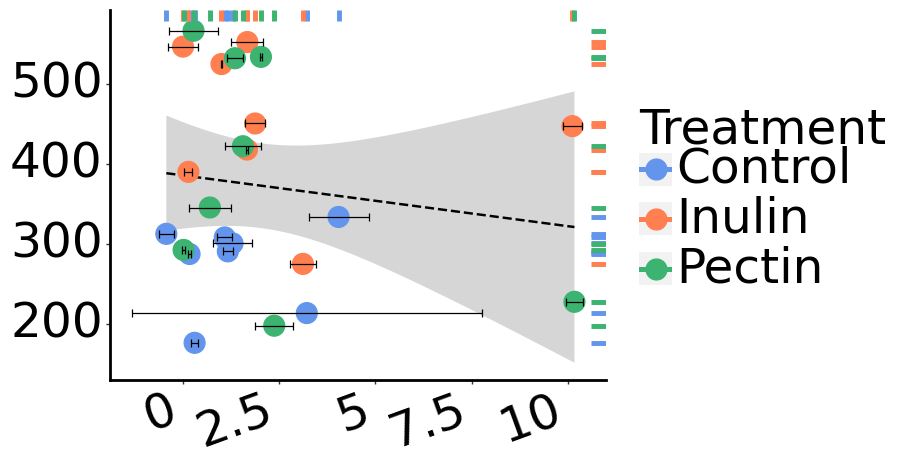

<ggplot: (8791569144372)>

In [50]:
fig4 = (ggplot(
    res, aes(x = 'acetateMeasured', y = 'acetatePredicted'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 8)
    # +geom_smooth(aes(groups = 'treatment', color = 'treatment', fill = 'treatment'),
    #              method = 'lm', linetype = '--')
    # +geom_errorbar(aes(x = 'acetateMeasured', 
    #                    ymin = 'acetatePredicted - acetatePredictedSEM',
    #                    ymax = 'acetatePredicted + acetatePredictedSEM'))
    +geom_errorbarh(aes(y = 'acetatePredicted', 
                       xmin = 'acetateMeasured - acetateMeasuredSEM',
                       xmax = 'acetateMeasured + acetateMeasuredSEM'), height = 10)
    +geom_rug(aes(color = 'treatment'),sides = 'tr', size = 2)
    +scale_color_manual(limits = ['Control','Inulin','Pectin'], 
                        values = ['cornflowerblue', 'coral', 'mediumseagreen'])
    +scale_fill_manual(limits = ['Control','Inulin','Pectin'], 
                       values = ['cornflowerblue', 'coral', 'mediumseagreen'])
    +labs(title='',
          x='',
          y = '', 
          color = 'Treatment',fill = 'Treatment')
    +theme(text = element_text(size=35, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig4

/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 3 rows containing missing values.
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_errorbarh : Removed 3 rows containing missing values.


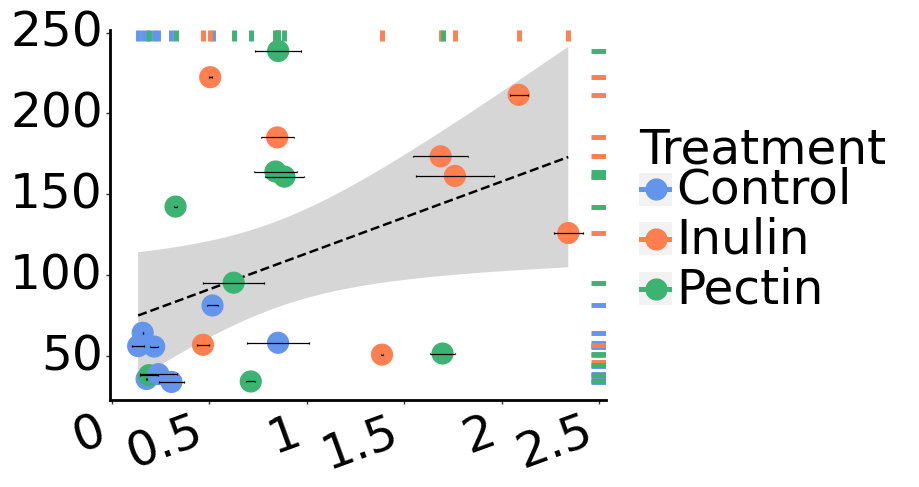

<ggplot: (8791580005497)>

In [51]:
fig5 = (ggplot(
    res, aes(x = 'butyrateMeasured', y = 'butyratePredicted'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 8)
    # +geom_smooth(aes(groups = 'treatment', color = 'treatment', fill = 'treatment'),
    #              method = 'lm', linetype = '--')
    # +geom_errorbar(aes(x = 'butyrateMeasured', 
    #                    ymin = 'butyratePredicted - butyratePredictedSEM',
    #                    ymax = 'butyratePredicted + butyratePredictedSEM'), width = .1)
    +geom_errorbarh(aes(y = 'butyratePredicted', 
                       xmin = 'butyrateMeasured - butyrateMeasuredSEM',
                       xmax = 'butyrateMeasured + butyrateMeasuredSEM'), height = 1)
    +geom_rug(aes(color = 'treatment'),sides = 'tr', size = 2)
    +scale_color_manual(limits = ['Control','Inulin','Pectin'], 
                        values = ['cornflowerblue', 'coral', 'mediumseagreen'])
    +scale_fill_manual(limits = ['Control','Inulin','Pectin'], 
                       values = ['cornflowerblue', 'coral', 'mediumseagreen'])    
    +labs(title='',
          x='',
          y = '', 
         color = 'Treatment', fill = 'Treatment')
     +theme(text = element_text(size=35, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig5

/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 3 rows containing missing values.
/users/nbohmann/miniconda3/envs/micom2022/lib/python3.8/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_errorbarh : Removed 3 rows containing missing values.


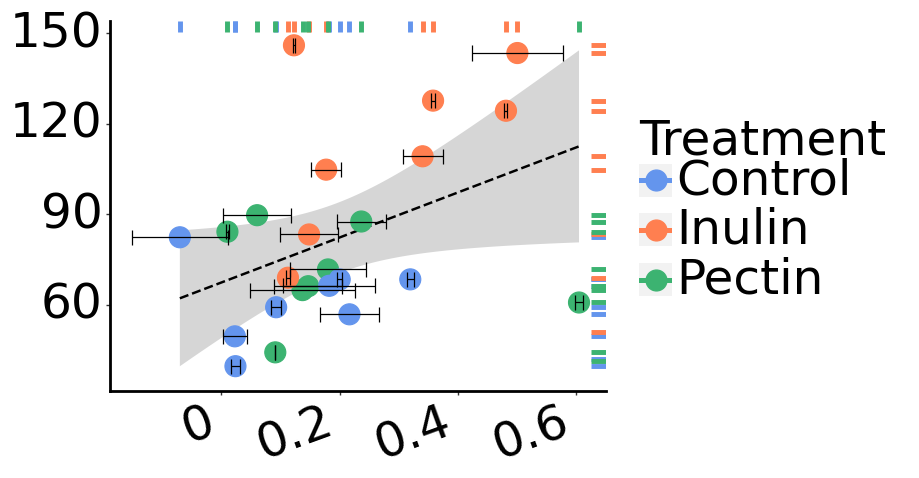

<ggplot: (8791577840818)>

In [52]:
fig6 = (ggplot(
    res, aes(x = 'propionateMeasured', y = 'propionatePredicted'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 8)
    # +geom_smooth(aes(groups = 'treatment', color = 'treatment', fill = 'treatment'),
    #              method = 'lm', linetype = '--', alpha = .5)
    # +geom_errorbar(aes(x = 'propionateMeasured', 
    #                    ymin = 'propionatePredicted - propionatePredictedSEM',
    #                    ymax = 'propionatePredicted + propionatePredictedSEM'), width = .1)
    +geom_errorbarh(aes(y = 'propionatePredicted', 
                       xmin = 'propionateMeasured - propionateMeasuredSEM',
                       xmax = 'propionateMeasured + propionateMeasuredSEM'), height = 5)
    +geom_rug(aes(color = 'treatment'),sides = 'tr', size = 2)
    +scale_color_manual(limits = ['Control','Inulin','Pectin'], 
                        values = ['cornflowerblue', 'coral', 'mediumseagreen'])
    +scale_fill_manual(limits = ['Control','Inulin','Pectin'], 
                       values = ['cornflowerblue', 'coral', 'mediumseagreen'])
   
    +labs(title='',
          x='',
          y = '', 
         color = 'Treatment', fill = 'Treatment')
     +theme(text = element_text(size=35, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig6

In [55]:
res.dropna(inplace = True)

In [57]:
scipy.stats.linregress(res['propionateMeasured'],
                       res['propionatePredicted'])

LinregressResult(slope=74.43590370872003, intercept=67.46865423798911, rvalue=0.41504578229671507, pvalue=0.043719281810907534, stderr=34.7873465834803, intercept_stderr=8.843999186037953)

In [ ]:
stat_micom, p_micom = scipy.stats.ttest_rel(res[res.treatment.str.contains('Control')]['acetatePredicted'],
                      res[res.treatment.str.contains('Inulin')]['acetatePredicted'])
stat_exp, p_exp = scipy.stats.ttest_rel(res[res.treatment.str.contains('Control')]['acetateMeasured'],
                      res[res.treatment.str.contains('Inulin')]['acetateMeasured'])
print('MICOM:'+str(p_micom))
print('Experimental:'+str(p_exp))

In [ ]:
ggsave(fig4,'/users/nbohmann/acetate_sp.png', dpi = 300)
ggsave(fig5,'/users/nbohmann/butyrate_sp.png', dpi = 300)
ggsave(fig6,'/users/nbohmann/propionate_sp.png', dpi = 300)
